---
layout: post
title: Blog Post 6
---

In this Blog Post, we will develop and assess a fake news classifier using Tensorflow.

#### Data Source
Our data for this assignment comes from the article

- Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138).

Prof.Chodrow accessed it from [Kaggle](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset). He has done a small amount of data cleaning, and performed a train-test split. We will use the his version of data.

## §1. Acquire Training Data

We will start be creating a block of code that will hold our import statements.

In [1]:
#importing packages 
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Now let's access the training data provided by Prof. Chodrow.

In [2]:
train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"
train_set = pd.read_csv(train_url)

In [3]:
train_set.head(10)

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0
5,13616,North Korea says successfully launches new ICB...,North Korea successfully launched a new type o...,0
6,1707,California lawmakers take anti-Trump stance as...,"SACRAMENTO, Calif.California lawmakers voted t...",0
7,15299,New Delhi declares emergency as toxic smog thi...,NEW The Indian capital declared a pollution em...,0
8,4049,"AUDIO: Hannity Has RACIST Meltdown, Wants To ...",Nobody would have ever said this about any of ...,1
9,12166,Forgetful ministers keep Mugabe's name alive a...,Zimbabwe s Robert Mugabe may have been deposed...,0


Take a look at this data. We can tell each row of the data corresponds to an article. The title column gives the title of the article, while the text column gives the full article text. The final column, called fake, is `0` if the article is true and `1` if the article contains fake news, as determined by the authors of the paper above.

## §2. Make a Dataset

TensorFlow Dataset has a special `Dataset` class that's easy to organize when writing data pipelines.

In this section, we want to write a function called `make_dataset` to construct our Datasetthat has all the stopwrods removed from text and title and takes two inputs `text` and `title` of the form `("title", "text")`. We will batch our dataset. Batching causes our model to train on chunks of data rather than individual rows. This can sometimes reduce accuracy, but can also greatly increase the speed of training. Finding a balance is key. batches of 100 rows to work well.

In [4]:
# define stopwords 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def make_dataset(df):
  # remove stopwords from text and title
  df = df[['text','title', "fake"]].apply(lambda x: [item for item in x if item not in stop])
  # construct tf dataset
  # construct dataset from a tuple of dictionaries
  # the first dictionary is the inputs 
  # the second dictionary specifies the output
  data = tf.data.Dataset.from_tensor_slices(
      ({
          "title" : df[["title"]],
          "text"  : df[["text"]]
      },
       {
           "fake" : df[["fake"]]
        }))

  # batch the dataset to increase the speed of training
  data = data.batch(100)
  
  return data

Now, we call the function `make_dataset` on the training dataframe to produce a `Dataset`.

In [6]:
Dataset = make_dataset(train_set)

### Validation Data

Next, we are going to perform a train/validation split.We will split of 20% of the training set to use for validation.

In [7]:
Dataset = Dataset.shuffle(buffer_size = len(Dataset))

train_size = int(0.8*len(Dataset))

train = Dataset.take(train_size)
val   = Dataset.skip(train_size)

len(train), len(val)

(180, 45)

### Base Rate

The base rate refers to the accuracy of a model that always makes the same guess. We will determine the base rate for this data set by examining the labels on the training set to see the proportion of the most frequent label.

We would like to compute the number of rows in our training data with label 0 (true news) and label 1 (fake news). Why do we care about this? We need to know the most frequent label since our baseline machine learning model is likely to guess that label!


In [8]:
train_set.groupby("fake").size()

fake
0    10709
1    11740
dtype: int64

`1` is more frequent than `0`. We can then calculate the base rate:

In [9]:
train_set["fake"].mean()

0.522963160942581

Our base rate is 52.29%.

## §3. Create Models

We will use TensorFlow models to offer a perspective on the following question:

**When detecting fake news, is it most effective to focus on only the title of the article, the full text of the article, or both?**

Before building our models, we will first standarize our data.

In [10]:
##Data Prep: Vectorizing our Data
#Does frequency of capitalization and punctuation give indication for authenticity of article?
size_vocabulary = 2000
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation 

vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
  ) 

We need to adapt the vectorization layer to the titles. In the adaptation process, the vectorization layer learns what words are common in the title.

In [11]:
vectorize_layer.adapt(train.map(lambda x, y: x['title']))

We will create a share embbedding layer for the models.

In [12]:
# shared embedding layer

embedding = layers.Embedding(size_vocabulary, 3, name = "embedding")

### Model 1

In this model, we will only use the article `title` as an input. Since the title column contains just one entry for each piece of news, so the shape is (1,) (a tuple of length 1). 

In [13]:
# input
title_input = keras.Input(
    shape = (1,), 
    name = "title",
    dtype = "string"
)

In [14]:
# layers for processing the title, pretty much the same as from our lecture
# on text classification
title_features = vectorize_layer(title_input)
title_features = embedding(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.GlobalAveragePooling1D()(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.Dense(32, activation='relu')(title_features)

In [15]:
output = layers.Dense(2, name = 'fake')(title_features)

In [16]:
model1 = keras.Model(
    inputs = title_input,
    outputs = output
)

Let's visualize our first model.

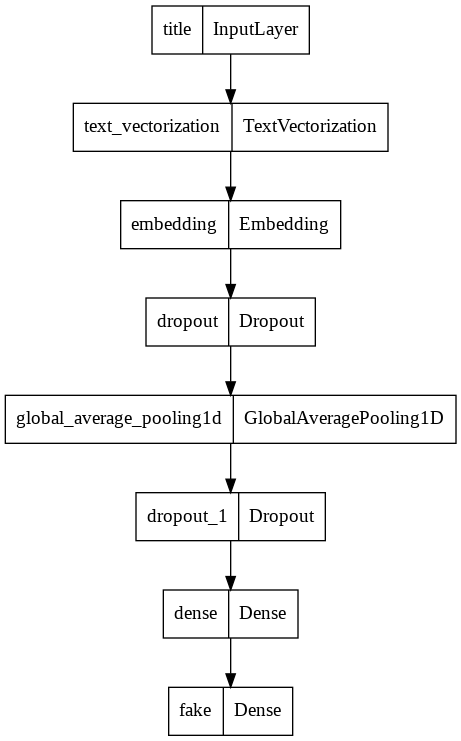

In [17]:
keras.utils.plot_model(model1)

![Blog-Post-6-Plot1.png](https://raw.githubusercontent.com/JadenWSR/JadenWSR.github.io/master/images/Blog-Post-6-Plot1.png)

In [18]:
model1.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [19]:
model1_history = model1.fit(train, 
                    validation_data=val,
                    epochs = 50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['text'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


180/180 [==============================] - 5s 16ms/step - loss: 0.6217 - accuracy: 0.7398 - val_loss: 0.4686 - val_accuracy: 0.8904
Epoch 2/50
180/180 [==============================] - 2s 13ms/step - loss: 0.3739 - accuracy: 0.8633 - val_loss: 0.2600 - val_accuracy: 0.9193
Epoch 3/50
180/180 [==============================] - 3s 15ms/step - loss: 0.2497 - accuracy: 0.9094 - val_loss: 0.1892 - val_accuracy: 0.9351
Epoch 4/50
180/180 [==============================] - 3s 14ms/step - loss: 0.1987 - accuracy: 0.9301 - val_loss: 0.1525 - val_accuracy: 0.9444
Epoch 5/50
180/180 [==============================] - 3s 15ms/step - loss: 0.1668 - accuracy: 0.9414 - val_loss: 0.1309 - val_accuracy: 0.9518
Epoch 6/50
180/180 [==============================] - 2s 13ms/step - loss: 0.1533 - accuracy: 0.9441 - val_loss: 0.1079 - val_accuracy: 0.9643
Epoch 7/50
180/180 [==============================] - 3s 14ms/step - loss: 0.1418 - accuracy: 0.9469 - val_loss: 0.1065 - val_accuracy: 0.9607
Epoch 8/50

In [20]:
def visualize_history(history, baseline):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.axhline(y= baseline, color='black', label='Baseline accuracy = {m}%'.format(m=round(baseline*100, 1)))
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

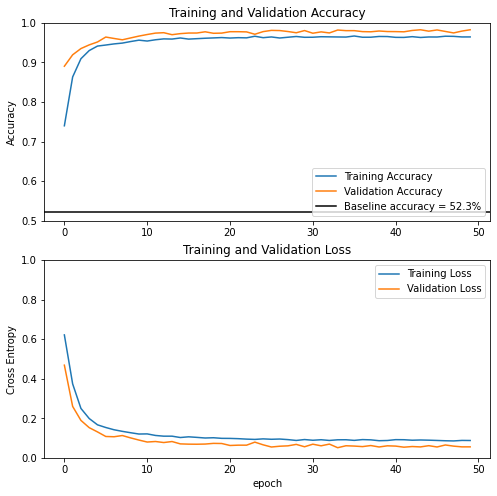

In [21]:
visualize_history(model1_history, 0.5229)

![Blog-Post-6-Plot2.png](https://raw.githubusercontent.com/JadenWSR/JadenWSR.github.io/master/images/Blog-Post-6-Plot2.png)

In [22]:
model1.evaluate(val)

45/45 [==============================] - 0s 4ms/step - loss: 0.0625 - accuracy: 0.9773


[0.06247315928339958, 0.9772982597351074]

It seems that our title model can accurately assess whether or not an article is fake about **97.73%** of the time! That is pretty impressive!

### Model 2

In this model, we will only use the article `text` as an input. Since the text column contains just one entry for each piece of news, so the shape is (1,) (a tuple of length 1). 

In [23]:
# input
text_input = keras.Input(
    shape = (1,), 
    name = "text",
    dtype = "string"
)

In [24]:
# layers for processing the text, pretty much the same as from our lecture
# on text classification
text_features = vectorize_layer(text_input)
text_features = embedding(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.GlobalAveragePooling1D()(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.Dense(32, activation='relu')(text_features)

In [25]:
output = layers.Dense(2, name = 'fake')(text_features)

In [26]:
model2 = keras.Model(
    inputs = text_input,
    outputs = output
)

Let's visualize our text model.

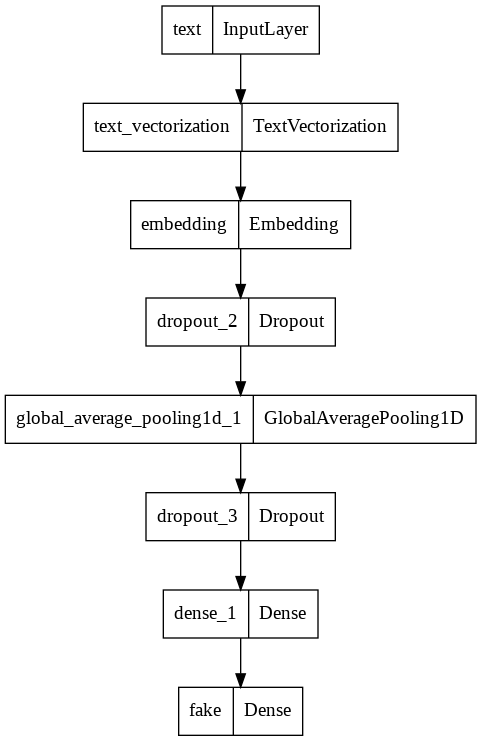

In [27]:
keras.utils.plot_model(model2)

![Blog-Post-6-Plot3.png](https://raw.githubusercontent.com/JadenWSR/JadenWSR.github.io/master/images/Blog-Post-6-Plot3.png)

In [28]:
model2.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [29]:
model2_history = model2.fit(train, 
                    validation_data=val,
                    epochs = 50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['title'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


180/180 [==============================] - 6s 27ms/step - loss: 0.6783 - accuracy: 0.6722 - val_loss: 0.6520 - val_accuracy: 0.8589
Epoch 2/50
180/180 [==============================] - 4s 22ms/step - loss: 0.5837 - accuracy: 0.8402 - val_loss: 0.4938 - val_accuracy: 0.9204
Epoch 3/50
180/180 [==============================] - 4s 22ms/step - loss: 0.4234 - accuracy: 0.8987 - val_loss: 0.3436 - val_accuracy: 0.9202
Epoch 4/50
180/180 [==============================] - 4s 22ms/step - loss: 0.3206 - accuracy: 0.9251 - val_loss: 0.2570 - val_accuracy: 0.9493
Epoch 5/50
180/180 [==============================] - 4s 22ms/step - loss: 0.2584 - accuracy: 0.9355 - val_loss: 0.2285 - val_accuracy: 0.9542
Epoch 6/50
180/180 [==============================] - 4s 22ms/step - loss: 0.2249 - accuracy: 0.9424 - val_loss: 0.2051 - val_accuracy: 0.9564
Epoch 7/50
180/180 [==============================] - 4s 22ms/step - loss: 0.2031 - accuracy: 0.9507 - val_loss: 0.1796 - val_accuracy: 0.9620
Epoch 8/50

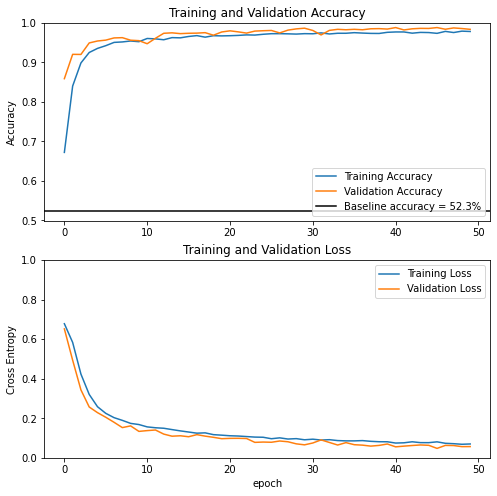

In [30]:
visualize_history(model2_history, 0.5229)

![Blog-Post-6-Plot4.png](https://raw.githubusercontent.com/JadenWSR/JadenWSR.github.io/master/images/Blog-Post-6-Plot4.png)

In [31]:
model2.evaluate(val)

45/45 [==============================] - 1s 13ms/step - loss: 0.0525 - accuracy: 0.9849


[0.05247829854488373, 0.9848889112472534]

Similar as model1, it seems that our text model can accurately assess whether or not an article is fake about **98.49%** of the time! Model2 is doing slightly better than model1.

### Model 3

In this model, we will both the article title and the article text as input.

Let’s first shuffle our original data so that our model is not able to learn from prior data.

In [32]:
## Creating a new Dataset to work with!
dataset = Dataset.shuffle(buffer_size = len(Dataset))

train_size = int(0.8 *len(dataset))
val_size = int(0.2 * len(dataset))

train_2 = dataset.take(train_size) 
val_2 = dataset.skip(train_size).take(val_size)

Here's simultaneously the most important and most boring part of the whole model: we are going to `concatenate` the output of the `title` pipeline with the output of the `text` pipeline:

In [33]:
main = layers.concatenate([title_features, text_features], axis = 1)

Finally, let's pass the consolidated set of computed features through a few more Dense layers. Remember that the very last Dense layer should have a number of outputs equal to the number of classes in the data.

Observe that the output layer has a name, and that this name matches the key corresponding to the target data in the Datasets we will pass to the model. This is how TensorFlow knows which part of our data set to compare against the outputs!

In [34]:
main = layers.Dense(32, activation='relu')(main)
output = layers.Dense(2, name = "fake")(main)

In [35]:
model3 = keras.Model(
    inputs = [title_input, text_input],
    outputs = output
)

Let's visualize our third model.

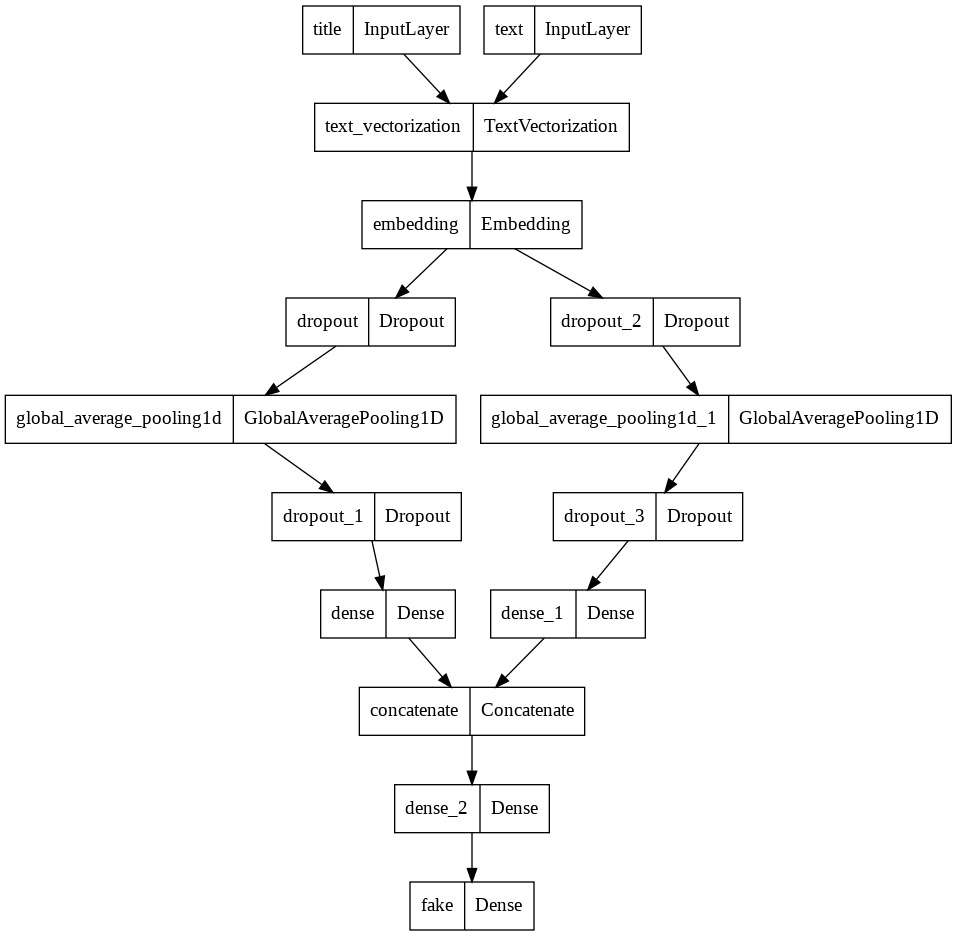

In [36]:
keras.utils.plot_model(model3)

![Blog-Post-6-Plot5.png](https://raw.githubusercontent.com/JadenWSR/JadenWSR.github.io/master/images/Blog-Post-6-Plot5.png)

In [37]:
model3.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [38]:
model3_history = model3.fit(train_2, 
                    validation_data=val_2,
                    epochs = 70)

Epoch 1/70
180/180 [==============================] - 6s 25ms/step - loss: 0.1753 - accuracy: 0.9530 - val_loss: 0.0578 - val_accuracy: 0.9807
Epoch 2/70
180/180 [==============================] - 4s 24ms/step - loss: 0.0583 - accuracy: 0.9816 - val_loss: 0.0342 - val_accuracy: 0.9891
Epoch 3/70
180/180 [==============================] - 4s 24ms/step - loss: 0.0496 - accuracy: 0.9828 - val_loss: 0.0312 - val_accuracy: 0.9902
Epoch 4/70
180/180 [==============================] - 4s 24ms/step - loss: 0.0441 - accuracy: 0.9851 - val_loss: 0.0314 - val_accuracy: 0.9907
Epoch 5/70
180/180 [==============================] - 4s 24ms/step - loss: 0.0459 - accuracy: 0.9851 - val_loss: 0.0354 - val_accuracy: 0.9881
Epoch 6/70
180/180 [==============================] - 4s 24ms/step - loss: 0.0437 - accuracy: 0.9861 - val_loss: 0.0272 - val_accuracy: 0.9897
Epoch 7/70
180/180 [==============================] - 4s 24ms/step - loss: 0.0424 - accuracy: 0.9853 - val_loss: 0.0312 - val_accuracy: 0.9907

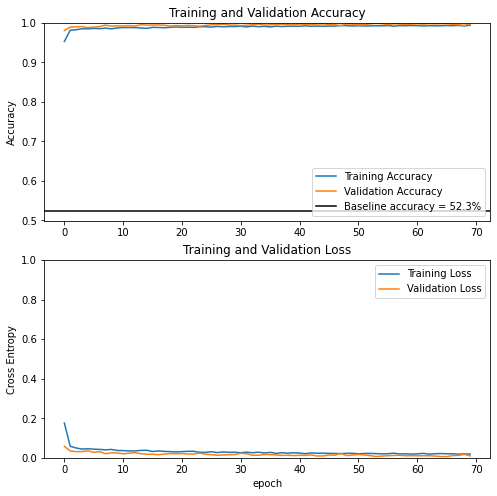

In [39]:
visualize_history(model3_history, 0.5229)

![Blog-Post-6-Plot6.png](https://raw.githubusercontent.com/JadenWSR/JadenWSR.github.io/master/images/Blog-Post-6-Plot6.png)

In [40]:
model3.evaluate(val)

45/45 [==============================] - 1s 14ms/step - loss: 0.0068 - accuracy: 0.9982


[0.00680549768730998, 0.9982222318649292]

It seems that our mixed model can accurately assess whether or not an article is fake about **99.82%** of the time! This is the best model among all 3 models.

## §4. Model Evaluation

By testing our model performance on on validation data, we have picked **model3**, the mixed model as our best model. Then, let's test our model performance on unseen test data. 

Let's read in and preprocess the test dataset.

In [41]:
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"
test_set = pd.read_csv(test_url)

Take a look at our test data:

In [42]:
test_set.head(10)

,Unnamed: 0,title,text,fake
0,420,"CNN And MSNBC Destroy Trump, Black Out His Fa...",Donald Trump practically does something to cri...,1
1,14902,Exclusive: Kremlin tells companies to deliver ...,The Kremlin wants good news. The Russian lead...,0
2,322,Golden State Warriors Coach Just WRECKED Trum...,"On Saturday, the man we re forced to call Pre...",1
3,16108,"Putin opens monument to Stalin's victims, diss...",President Vladimir Putin inaugurated a monumen...,0
4,10304,BREAKING: DNC HACKER FIRED For Bank Fraud…Blam...,Apparently breaking the law and scamming the g...,1
5,1873,"Trump, lawmakers agree on disaster aid, debt l...",U.S. President Donald Trump and congressional ...,0
6,8577,McConnell calls Army captain Khan 'an American...,"Senate Majority Leader Mitch McConnell, a Repu...",0
7,12993,"Air strike reported near Somalia's capital, of...",An air strike hit a village south of Somalia s...,0
8,21793,BALTIMORE POLICE UNION WANTS AN INDEPENDANT PR...,The Police Union came out almost immediately a...,1
9,17454,TROLL CONGRESSWOMAN WANTS YOU TO SELL YOUR GUN...,It s not for her to decide! We have the Second...,1


In [43]:
test = make_dataset(test_set)

In [44]:
model3.evaluate(test)

225/225 [==============================] - 7s 29ms/step - loss: 0.0651 - accuracy: 0.9833


[0.0650782659649849, 0.9833400249481201]

If we used this model as a fake news detector, we would be right about **98.33%** of the time. Not bad!

## §5. Embedding Visualization

A word embedding refers to a representation of a word in a vector space. Each word is assigned an individual vector. The general aim of a word embedding is to create a representation such that words with related meanings are close to each other in a vector space, while words with different meanings are farther apart. One usually hopes for the directions connecting words to be meaningful as well.

Word embeddings are often produced as intermediate stages in many machine learning algorithms. In fact, we already made one -- it's the Embedding layer at the base of our model. Let's take a look at the embedding layer to see how our own model represents words in a vector space.

We chose to create a 3-dimensional embedding when constructing our model. This is fine for today, but state-of-the-art embeddings will typically have a much higher number of dimensions. For example, the Embedding Projector demo supplied by TensorFlow uses a default dimension of 200.

In [53]:
weights = model3.get_layer('embedding').get_weights()[0] # get the weights from the embedding layer
vocab = vectorize_layer.get_vocabulary()                # get the vocabulary from our data prep for later

In [54]:
weights

array([[-1.19012012e-03, -1.86443608e-03,  5.70721895e-05],
       [-9.08479914e-02, -1.06032185e-01,  1.02904350e-01],
       [-4.69999723e-02, -2.33739950e-02,  1.03678256e-02],
       ...,
       [-2.67219281e+00, -2.67441988e+00,  2.71985936e+00],
       [ 9.47235227e-01,  1.05525899e+00, -9.80252922e-01],
       [-9.07754183e-01, -1.01780140e+00,  1.08219540e+00]], dtype=float32)

The collection of weights is 3-dimensional. For plotting in 2 dimensions, we have several choices for how to reduce the data to a 2d representation. A very simple and standard approach is our friend, principal component analysis (PCA).

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
weights = pca.fit_transform(weights)
# Make a data frame from our results:
embedding_df = pd.DataFrame({
    'word' : vocab, 
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})

In [56]:
embedding_df

,word,x0,x1
0,,0.202498,-0.005181
1,[UNK],0.031107,0.003748
2,to,0.157942,-0.031269
3,trump,-0.122674,-0.053198
4,in,0.745727,0.019837
...,...,...,...
1995,deadline,-0.051585,0.061718
1996,damage,1.552809,-0.044488
1997,daily,-4.452883,-0.024606
1998,cuban,1.926826,-0.029043


In [79]:
import plotly.express as px
fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1", 
                 size = list(np.ones(len(embedding_df))),
                 size_max = 5,
                 hover_name = "word")
fig.update_layout(plot_bgcolor="white")
fig.show()

{% include Blog-Post-6-Plot7.html %}

Cool, we made a word embedding! This embedding seems to have learned some reasonable associations. For example, inspection the plot by eye,we see that words like "shot", "destroy", and "lynch" are relatively close to each other. So are "voting", "Wall", and "donors", as well as "fired", "leaving", and "considering." Let's take a closer look. It seems that words in the direction towards the bottom right of the visualization have to do with politics and international situation. We can see this due to the mentions of “turkeys”,”capital”, “ireland”, "macron" and "zimbabwe".

In [77]:
#getting a closer look at specific regions in our 2D representation
embedding_df[(embedding_df['x0'] > 3) & (embedding_df['x0'] < 5) & (embedding_df['x1'] < 0)]

,word,x0,x1,highlight,size
130,twitter,4.050928,-0.027451,0,1.0
361,said,4.437564,-0.008937,0,1.0
478,macron,4.518110,-0.001168,0,1.0
510,turkish,3.300364,-0.067426,0,1.0
597,repeal,3.547341,-0.029784,0,1.0
668,denies,4.086952,-0.074108,0,1.0
711,spain,3.610839,-0.058848,0,1.0
845,turkeys,3.287574,-0.043082,0,1.0
933,comment,3.082336,-0.193297,0,1.0
950,highlights,4.261396,-0.104503,0,1.0


### Bias

Whenever we create a machine learning model that might conceivably have impact on the thoughts or actions of human beings, we have a responsibility to understand the limitations and biases of that model. Biases can enter into machine learning models through several routes, including the data used as well as choices made by the modeler along the way. For example, in our case:

- Data: we used data from a popular news source.
- Modeler choice: we only used data corresponding to a certain subset of labels.

With these considerations in mind, let's see what kinds of words our model associates with female and male genders.

In [72]:
feminine = ["she", "her", "woman"]
masculine = ["he", "him", "man"]

highlight_1 = ["strong", "powerful", "smart",     "thinking"]
highlight_2 = ["hot",    "sexy",     "beautiful", "shopping"]

def gender_mapper(x):
    if x in feminine:
        return 1
    elif x in masculine:
        return 4
    elif x in highlight_1:
        return 3
    elif x in highlight_2:
        return 2
    else:
        return 0

embedding_df["highlight"] = embedding_df["word"].apply(gender_mapper)
embedding_df["size"]      = np.array(1.0 + 50*(embedding_df["highlight"] > 0))

In [78]:
import plotly.express as px 

fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1", 
                 color = "highlight",
                 size = list(embedding_df["size"]),
                 size_max = 10,
                 hover_name = "word")

fig.show()

{% include Blog-Post-6-Plot8.html %}

Based on above plot, our text classification model's word embedding is not sexist.

Congratulations! You are now able to construct an extremely accurate model to classify authenticity of news article.